# File Name: simple_automatic_evaluation_task.ipynb
### Location: Chapter 11
### Purpose: 
#####             1.  Create automated evaluation job for text summarization
#####             2.  Get automated evaluation job status
#####             3.  Test the evaluation score for Accuracy, Toxicity, and Robustness
##### Dependency: simple-sageMaker-bedrock.ipynb at Chapter 3 should work properly. 
# <ins>-----------------------------------------------------------------------------------</ins>

# <ins>Amazon SageMaker Classic</ins>
#### Those who are new to Amazon SageMaker Classic. Follow the link for the details. https://docs.aws.amazon.com/sagemaker/latest/dg/studio.html

# <ins>Environment setup of Kernel</ins>
##### Fill "Image" as "Data Science"
##### Fill "Kernel" as "Python 3"
##### Fill "Instance type" as "ml-t3-medium"
##### Fill "Start-up script" as "No Scripts"
##### Click "Select"

###### Refer https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-create-open.html for details.

# <ins>Mandatory installation on the kernel through pip</ins>

##### This lab will work with below software version. But, if you are trying with latest version of boto3, awscli, and botocore. This code may fail. You might need to change the corresponding api. 

##### You will see pip dependency errors. you can safely ignore these errors and continue executing rest of the cell. 

In [ ]:
%%time 

%pip install --upgrade pip
%pip install --no-build-isolation --force-reinstall -q \
    "boto3>=1.34.84" \
    "awscli>=1.32.84" \
    "botocore>=1.34.84" \
    "langchain" \
    "typing_extensions" \
    "pypdf" \
    "urllib3" \
    "jsonlines" \
    "datasets" \
    "pandas" \
    "matplotlib" \
    "ipywidgets>=7,<8"

# <ins>Disclaimer</ins>

##### You will see pip dependency errors. you can safely ignore these errors and continue executing rest of the cell.

# <ins>Restart the kernel</ins>

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

# <ins>Python package import</ins>

##### boto3 offers various clients for Amazon Bedrock to execute various actions.
##### botocore is a low-level interface to AWS tools, while boto3 is built on top of botocore and provides additional features

In [ ]:
import warnings
import json
import os
import sys
import boto3 
import time
import pprint
from datasets import load_dataset
import random
import jsonlines
import botocore
from datetime import datetime

### Ignore warning 

In [ ]:
warnings.filterwarnings('ignore')

## Define important environment variable

In [ ]:
# Try-except block to handle potential errors
try:
    # Create a new Boto3 session to interact with AWS services
    boto3_session_name = boto3.session.Session()

    # Retrieve the current AWS region from the session
    aws_region_name = boto3_session_name.region_name
    
    # Create a new Boto3 bedrock client to interact with AWS services
    boto3_bedrock_client = boto3.client('bedrock')
    
    # Create a new Boto3 bedrock runtime client to interact with AWS services
    boto3_bedrock_runtime_client = boto3.client('bedrock-runtime')
    
    # Create an STS client to interact with AWS Security Token Service (STS)
    sts_client = boto3.client('sts')
    
    # Create an STS client to interact with AWS Security Token Service (STS)
    iam_client = boto3.client('iam')
    
    # Create an S3 client to interact with Amazon S3
    s3_client = boto3.client('s3')

    # Get the AWS account ID of the caller
    aws_account_id = sts_client.get_caller_identity()["Account"]
    
    # Generate a random suffix number between 200 and 900
    random_suffix = random.randrange(200, 900)
    
    # Generate a suffix using the region and account ID for the S3 bucket name
    s3_suffix = f"{aws_region_name}-{aws_account_id}"

    # Define the name of the S3 bucket (you can replace this with your actual bucket name)
    s3_bucket_name = f'bedrock-model-eval-auto-{s3_suffix}-{random_suffix}'
    
    # Store all variables in a dictionary
    variables_store = {
        "boto3_session_name": boto3_session_name,
        "aws_region_name": aws_region_name,
        "boto3_bedrock_client": boto3_bedrock_client,
        "random_suffix": random_suffix,
        "boto3_bedrock_runtime_client": boto3_bedrock_runtime_client,
        "s3_suffix": s3_suffix,
        "s3_bucket_name": s3_bucket_name,
        "sts_client": sts_client,
        "aws_account_id": aws_account_id,
        "iam_client":iam_client,
        "s3_client": s3_client
    }

    # Print all variables
    for var_name, value in variables_store.items():
        print(f"{var_name}: {value}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")


### ---------------
##### The provided code snippet uses the AWS Boto3 library to manage an Amazon S3 bucket for a knowledge base data source. It begins by creating an S3 client and defines a bucket name, s3_bucket_name. A function, check_bucket_exists, checks whether the specified bucket exists by attempting to retrieve its metadata using the head_bucket method. If the bucket exists, a message is printed confirming its existence. If it does not exist (error code '404'), the function returns False. If the bucket is missing, the script proceeds to create it using the create_bucket method, ensuring the data source bucket is always available.

In [ ]:
%%time

# Check if s3 bucket exists, and if not create S3 bucket for knowledge base data source

# Try-except block to handle potential errors
try:

    # Define the bucket name (you can replace this with your actual bucket name)
    bucket_name = s3_bucket_name

    # Check if the bucket exists
    def check_bucket_exists(bucket_name):
        try:
            s3_client.head_bucket(Bucket=bucket_name)
            print(f"Bucket '{bucket_name}' already exists.")
            return True
        except botocore.exceptions.ClientError as e:
            error_code = e.response['Error']['Code']
            if error_code == '404':
                print(f"Bucket '{bucket_name}' does not exist.")
                return False
            else:
                raise e

    # If the bucket doesn't exist, create it
    if not check_bucket_exists(bucket_name):
        # Create the S3 bucket
        s3_client.create_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' created successfully.")

except botocore.exceptions.BotoCoreError as boto_error:
    print(f"An error occurred with Boto3: {boto_error}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Understand dataset 

### Source of the datasets: https://huggingface.co/datasets/Harvard/gigaword?row=3

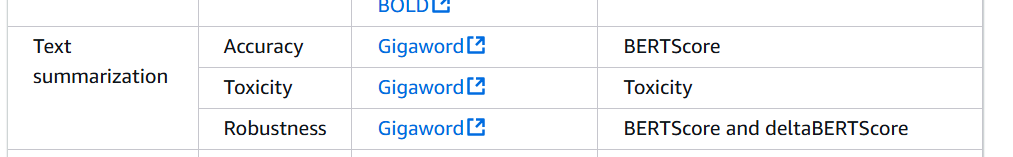

You will conduct an automated evaluation for "Text Summarization" use cases, measuring key metrics such as accuracy, toxicity, and robustness using standard datasets provided by Amazon. The computed metrics include accuracy measured with BERTScore, toxicity assessed with the Toxicity dataset, and robustness evaluated using BERTScore.

# Fine out role ARN

In [ ]:
%%time

# Find out IAM role and ARN for this session

def find_iam_role_by_name_substring(substring):
    try:
        # Use list_roles to retrieve IAM roles
        response = iam_client.list_roles()

        # Filter roles by name that contains the substring
        matching_roles = [role for role in response['Roles'] if substring in role['RoleName']]

        if matching_roles:
            for role in matching_roles:
                print(f"Found Role: {role['RoleName']} | ARN: {role['Arn']}")
                genaibookedbedrocksagemakerexecutionrolearn = role['Arn']
        else:
            print(f"No roles found with name containing '{substring}'.")
            
        return genaibookedbedrocksagemakerexecutionrolearn

    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Call the function with the desired substring
genaibookedbedrocksagemakerexecutionrolearn = find_iam_role_by_name_substring("GenAIBookBedrockSageMakerExecutionRole")

# Define variable for automated model evaluation

In [ ]:
# Define the job name for automated model evaluation of text summarization  
job_name_automated_model_eval = "text-summarization-automated-model-eval"  

# Provide a description for the evaluation job  
jobDescription = "Text summarization automated model evaluation"  

# Specify the Amazon Bedrock foundation model ARN to be evaluated  
modelIdentifier = "arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-text-lite-v1"  

# Define the S3 URI for storing the evaluation output  
outputDataConfig_s3Uri = "s3://" + s3_bucket_name + "/output/"

### The code defines inference parameters for evaluating a text summarization model using Amazon Bedrock. It then attempts to create an evaluation job with the specified model, inference parameters, and evaluation metrics, including accuracy, toxicity, and robustness, using the built-in Gigaword dataset. The job details, including the Amazon Resource Name (ARN), are printed upon successful execution. The code also incorporates error handling using a try-except block to catch and report Boto3-specific and general exceptions, ensuring robustness in case of failures.

In [ ]:
%%time

# Define the inference parameters for model evaluation
inference_params = {
    "inferenceConfig": {
        "maxTokens": 512,
        "temperature": 0.7,
        "topP": 0.9
    }
}

try:
    # Create the evaluation job
    job_request = boto3_bedrock_client.create_evaluation_job(
        jobName=job_name_automated_model_eval,
        jobDescription=jobDescription,
        roleArn=genaibookedbedrocksagemakerexecutionrolearn,  # Ensure this role has required permissions
        inferenceConfig={
            "models": [
                {
                    "bedrockModel": {
                        "modelIdentifier": modelIdentifier,
                        "inferenceParams": str(inference_params)  # Convert dictionary to JSON string
                    }
                }
            ]
        },
        outputDataConfig={"s3Uri": outputDataConfig_s3Uri},
        evaluationConfig={
            "automated": {
                "datasetMetricConfigs": [
                    {
                        "taskType": "Summarization",
                        "dataset": {"name": "Builtin.Gigaword"},
                        "metricNames": ["Builtin.Accuracy", "Builtin.Toxicity", "Builtin.Robustness"]
                    }
                ]
            }
        }
    )

    # Print job request details
    print("Evaluation job created successfully:", job_request)
    
    jobArn = job_request["jobArn"]
    print("jobArn:", job_request)

except boto3.exceptions.Boto3Error as e:
    # Handle Boto3-specific errors
    print(f"An error occurred while creating the evaluation job: {e}")

except Exception as e:
    # Handle any other general errors
    print(f"Unexpected error: {e}")


## The code continuously monitors the status of an evaluation job in Amazon Bedrock by polling at a defined interval of 120 seconds. It retrieves the job's status using the get_evaluation_job method and prints the current state. If the job status is either "Completed" or "Failed," the loop terminates, indicating that execution has finished. Otherwise, it waits for the specified polling interval before checking again. The code also includes exception handling to catch and report errors related to Boto3-specific issues or other unexpected failures, ensuring robustness in execution.

In [ ]:
%%time

# Polling interval in seconds
polling_interval = 120  

try:
    while True:
        # Fetch the current evaluation job status
        job_request = boto3_bedrock_client.get_evaluation_job(jobIdentifier=jobArn)

        # Print the job status
        job_status = job_request.get("status", "Unknown")
        print(f"Evaluation Job Status: {job_status}")

        # Break the loop if the job is complete or has failed
        if job_status in ["Completed", "Failed"]:
            print("Job execution finished.")
            break

        # Wait for the next check
        print(f"Waiting {polling_interval} seconds before checking again...")
        time.sleep(polling_interval)

except boto3.exceptions.Boto3Error as e:
    # Handle Boto3-specific errors
    print(f"An error occurred while retrieving the evaluation job status: {e}")

except Exception as e:
    # Handle general exceptions
    print(f"Unexpected error: {e}")

## Open the Amazon Bedrock console and navigate to the Inference and Assessment section from the left navigation panel.
## Click on Evaluations and check the status and results of the evaluation job in the right-side panel under Model Evaluations, using the job name you provided.

# End of NoteBook 

#### <ins>Step 1</ins> 

##### Please ensure that you close the kernel after using this notebook to avoid any potential charges to your account.

##### Process: Go to "Kernel" at top option. Choose "Shut Down Kernel". 
##### Refer https://docs.aws.amazon.com/sagemaker/latest/dg/studio-ui.html


#### <ins>Step 2</ins> 

#### If you are not executing any further lab of this Chapter 11
##### Uncomment and execute the below code to delete the provision thoughtput and custom model

## Open the Amazon Bedrock console and navigate to the Inference and Assessment section from the left navigation panel.
## Click on Evaluations and check the status and results of the evaluation job in the right-side panel under Model Evaluations, using the job name you provided. Then, delete the evaluation job to stop incuring cost anlong with file at S3 bucket